This code block imports necessary libraries and modules for audio feature extraction, CNN model creation, and data preprocessing. It includes:

os: for operating system-related functionalities.

librosa: for audio feature extraction. 

numpy: for numerical operations.

StratifiedKFold from sklearn.model_selection: for splitting data into train and test sets while maintaining class balance.

Sequential, Conv2D, MaxPooling2D, Flatten, Dense, Dropout from tensorflow.keras.layers: for building the CNN model architecture.

to_categorical from tensorflow.keras.utils: for converting class labels to categorical format.

from tensorflow.keras.utils import plot_model

This block sets up the initial environment and imports necessary tools for the subsequent cod

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
# Define the base directory path to the audio dataset
base_path = "/path/to/audio/dataset"

# Number of cross-validation folds
n_folds = 10

# Input shape for the CNN model (assuming grayscale images)
input_shape = (256, 256, 1)

# Determine the number of classes in the dataset by counting subdirectories in the base directory
num_classes = len(os.listdir(base_path))

# Batch size for training
batch_size = 64

# Number of epochs for training the model, set a higher value for better results
epochs = 50


In [ ]:
def extract_features(file_path, n_mels=256, hop_length=1024, n_fft=4096):
    """
    Extracts Mel spectrogram features from an audio file.
    
    Parameters:
    - file_path: Path to the audio file.
    - n_mels: Number of Mel frequency bins.
    - hop_length: Number of samples between successive frames.
    - n_fft: Number of samples used for each Fourier transform.
    
    Returns:
    - mel_spec_db: Mel spectrogram feature with added channel dimension.
    """
    # Load audio file using librosa
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')

    # Extract Mel spectrogram feature
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Convert to decibels (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize to fixed shape (256x256) for CNN input
    mel_spec_db = librosa.util.fix_length(mel_spec_db, size=input_shape[0], axis=1)

    # Add channel dimension
    mel_spec_db = mel_spec_db.reshape((*input_shape[:2], 1))

    # Print progress information
    print(f"Extracted features from {file_path}")

    return mel_spec_db

# Collect all audio file paths and labels
audio_paths = []
labels = []

for label, folder in enumerate(sorted(os.listdir(base_path))):
    folder_path = os.path.join(base_path, folder)
    # Check if the folder is actually a directory and not a system file like .DS_Store
    if os.path.isdir(folder_path):
        file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]
        audio_paths.extend(file_paths)
        labels.extend([label] * len(file_paths))

audio_paths = np.array(audio_paths)
labels = np.array(labels)



In [ ]:
def create_cnn_model(num_classes):
    """
    Creates a Convolutional Neural Network (CNN) model for classification.
    
    Parameters:
    - num_classes: Number of classes for classification.
    
    Returns:
    - model: CNN model compiled with specified optimizer, loss function, and metrics.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Plot the model architecture
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)
    
    return model


![CNN model Structure.png](<attachment:CNN model Structure.png>)
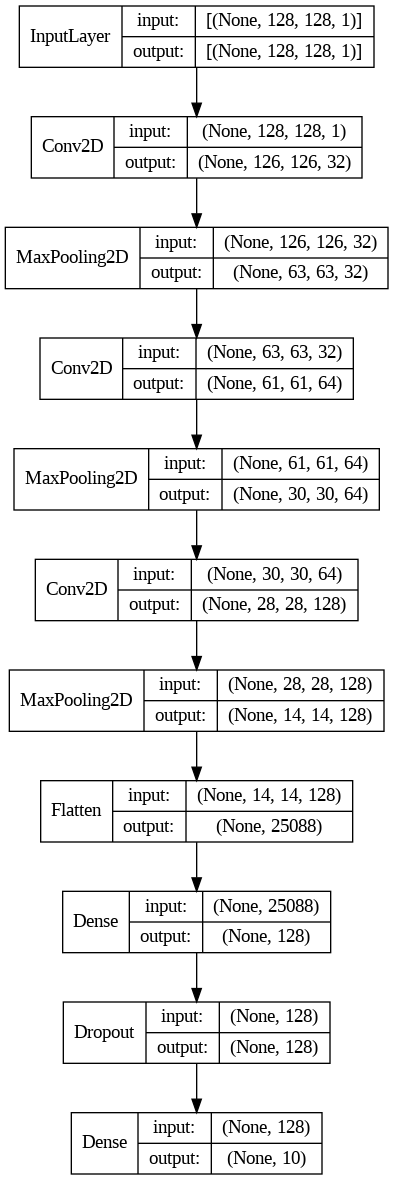

In [ ]:
# Precompute and store Mel spectrogram features
X_features = np.array([extract_features(file_path) for file_path in audio_paths])

# Initialize Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
accuracy_scores = []

# Iterate over each fold in the cross-validation
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_features, labels)):
    # Split features and labels into training and testing sets
    X_train_features, X_test_features = X_features[train_index], X_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Create and compile the CNN model
    model = create_cnn_model(num_classes)
    
    # Train the CNN model on the training data
    model.fit(X_train_features, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1)

    # Evaluate the model on test data and collect accuracy
    _, test_accuracy = model.evaluate(X_test_features, y_test_cat, verbose=0)
    accuracy_scores.append(test_accuracy)

    # Print the test accuracy for the current fold
    print(f"Fold {fold_idx + 1}: Test Accuracy = {test_accuracy}")

# Calculate and print average accuracy and standard deviation
mean_accuracy = np.mean(accuracy_scores)
std_dev = np.std(accuracy_scores)
print(f"Average Accuracy: {mean_accuracy:.4f} ± {std_dev:.4f}")
